In [2]:
import numpy as np
import torch
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Load the data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)


In [54]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh()
        )
        
        # latent space params
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid() 
        )
        
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.normal_(m.weight, mean=0.0, std=0.01)
                torch.nn.init.normal_(m.bias, mean=0.0, std=0.01)
                
        self.encoder.apply(init_weights)
        self.fc_mu.apply(init_weights)
        self.fc_var.apply(init_weights)
        self.decoder.apply(init_weights)
                
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return BCE + KLD

def wake_sleep_loss(recon_x, x, mu, log_var, z):
    wake_loss = -0.5 * torch.sum(log_var + (z - mu).pow(2) / log_var.exp())
    sleep_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    return wake_loss, sleep_loss

def compute_lower_bound(model, data_loader, device):
    total_bound = 0
    n_samples = 0
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device)
            recon_batch, mu, log_var = model(data)
            
            BCE = F.binary_cross_entropy(recon_batch, data.view(-1, 784), reduction='sum')
            KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            
            lower_bound = -(BCE + KLD)
            
            total_bound += lower_bound.item()
            n_samples += data.size(0)
    
    return total_bound / n_samples

def train_elbo(model, train_loader, optimizer, epoch, device):
    model = model.to(device)
    model.train()
    train_loss = 0
    lower_bounds = []
    samples = []
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            current_bound = compute_lower_bound(model, test_loader, device)
            lower_bounds.append(current_bound)
            samples.append(epoch * len(train_loader) + batch_idx)
    print(f'Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    return train_loss / len(train_loader.dataset), lower_bounds, samples

    
def train_wake_sleep(model, train_loader, wake_optimizer, sleep_optimizer, epoch, device):
    model.train()
    wake_loss_total = 0
    sleep_loss_total = 0
    lower_bounds = []
    samples = []
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        batch_size = data.size(0)
        
        wake_optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        z = model.reparameterize(mu, log_var)
        wake_loss, _ = wake_sleep_loss(recon_batch, data, mu, log_var, z)
        wake_loss.backward(retain_graph=True)
        wake_optimizer.step()
        
        sleep_optimizer.zero_grad()
        z_prior = torch.randn(batch_size, model.fc_mu.out_features).to(device)
        x_generated = model.decode(z_prior)
        mu_sleep, log_var_sleep = model.encode(x_generated.detach())
        _, sleep_loss = wake_sleep_loss(x_generated, data, mu_sleep, log_var_sleep, z_prior)
        sleep_loss.backward()
        sleep_optimizer.step()
        
        wake_loss_total += wake_loss.item()
        sleep_loss_total += sleep_loss.item()

        if batch_idx % 100 == 0:
            current_bound = compute_lower_bound(model, test_loader, device)
            lower_bounds.append(current_bound)
            samples.append(epoch * len(train_loader) + batch_idx)
        
    avg_wake_loss = wake_loss_total / len(train_loader.dataset)
    avg_sleep_loss = sleep_loss_total / len(train_loader.dataset)
    print(f'Epoch: {epoch} Average wake loss: {avg_wake_loss:.4f}, Average sleep loss: {avg_sleep_loss:.4f}')
    return avg_wake_loss, avg_sleep_loss, lower_bounds, samples



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 784  
hidden_dim = 500  
latent_dim = 20  

model_elbo = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer_elbo = optim.Adam(model_elbo.parameters(), lr=1e-3)

num_epochs = 50
loss_elbo = []
training_curves_elbo = {
        'lower_bound': [],
        'samples_processed': [],
    }
for epoch in range(1, num_epochs + 1):  
    loss, lower_bounds, samples = train_elbo(model_elbo, train_loader, optimizer_elbo, epoch, device)
    loss_elbo.append(loss)
    training_curves_elbo['lower_bound'].extend(lower_bounds)
    training_curves_elbo['samples_processed'].extend(samples)
    
model_ws = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer_ws = optim.Adam(model_ws.parameters(), lr=1e-3)
    
loss_wake_sleep = []
training_curves_ws = {
        'lower_bound': [],
        'samples_processed': [],
    }
for epoch in range(1, num_epochs + 1):
    loss, lower_bounds, samples = train_elbo(model_ws, train_loader, optimizer_ws, epoch, device)
    loss_wake_sleep.append(loss)
    training_curves_ws['lower_bound'].extend(lower_bounds)
    training_curves_ws['samples_processed'].extend(samples)

Epoch: 1 Average loss: 201.9283
Epoch: 2 Average loss: 149.5892
Epoch: 3 Average loss: 133.9729
Epoch: 4 Average loss: 124.0854
Epoch: 5 Average loss: 119.0163
Epoch: 6 Average loss: 115.2709
Epoch: 7 Average loss: 112.4791
Epoch: 8 Average loss: 110.5865
Epoch: 9 Average loss: 109.1241
Epoch: 10 Average loss: 108.0074
Epoch: 11 Average loss: 107.2110
Epoch: 12 Average loss: 106.4901
Epoch: 13 Average loss: 105.8659
Epoch: 14 Average loss: 105.4315
Epoch: 15 Average loss: 104.9609
Epoch: 16 Average loss: 104.6027
Epoch: 17 Average loss: 104.2535
Epoch: 18 Average loss: 104.0047
Epoch: 19 Average loss: 103.8200
Epoch: 20 Average loss: 103.5482
Epoch: 21 Average loss: 103.3434
Epoch: 22 Average loss: 103.1473
Epoch: 23 Average loss: 102.9666
Epoch: 24 Average loss: 102.8478
Epoch: 25 Average loss: 102.6655
Epoch: 26 Average loss: 102.5445
Epoch: 27 Average loss: 102.3907
Epoch: 28 Average loss: 102.3617
Epoch: 29 Average loss: 102.2201
Epoch: 30 Average loss: 102.1131
Epoch: 31 Average l

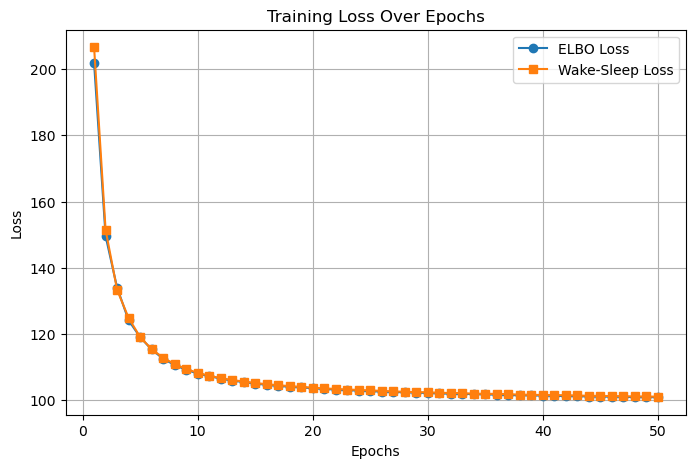

In [6]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_elbo, label="ELBO Loss", marker='o')
plt.plot(epochs, loss_wake_sleep, label="Wake-Sleep Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def plot_dimension_comparison(results, save_path=None):
    plt.figure(figsize=(12, 8))
    
    for nz, curves in results.items():
        plt.plot(curves['samples_processed'], curves['lower_bound'], 
                label=f'Nz = {nz}')
    
    plt.xlabel('Training samples processed')
    plt.ylabel('Average variational lower bound')
    plt.title('VAE Performance vs. Latent Space Dimension')
    plt.legend()
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

Epoch: 1 Average loss: 208.3427
Epoch: 2 Average loss: 183.0222
Epoch: 3 Average loss: 178.3191
Epoch: 4 Average loss: 175.1684
Epoch: 5 Average loss: 171.9431
Epoch: 6 Average loss: 169.2114
Epoch: 7 Average loss: 167.3763
Epoch: 8 Average loss: 165.8515
Epoch: 9 Average loss: 164.5396
Epoch: 10 Average loss: 163.4711
Epoch: 11 Average loss: 162.4323
Epoch: 12 Average loss: 161.4857
Epoch: 13 Average loss: 160.6090
Epoch: 14 Average loss: 159.8358
Epoch: 15 Average loss: 159.0023
Epoch: 16 Average loss: 158.3406
Epoch: 17 Average loss: 157.6731
Epoch: 18 Average loss: 157.1168
Epoch: 19 Average loss: 156.6251
Epoch: 20 Average loss: 156.1283
Epoch: 21 Average loss: 155.6427
Epoch: 22 Average loss: 155.3189
Epoch: 23 Average loss: 154.8896
Epoch: 24 Average loss: 154.5029
Epoch: 25 Average loss: 154.1671
Epoch: 26 Average loss: 153.7966
Epoch: 27 Average loss: 153.4703
Epoch: 28 Average loss: 153.1917
Epoch: 29 Average loss: 152.8930
Epoch: 30 Average loss: 152.6517
Epoch: 31 Average l

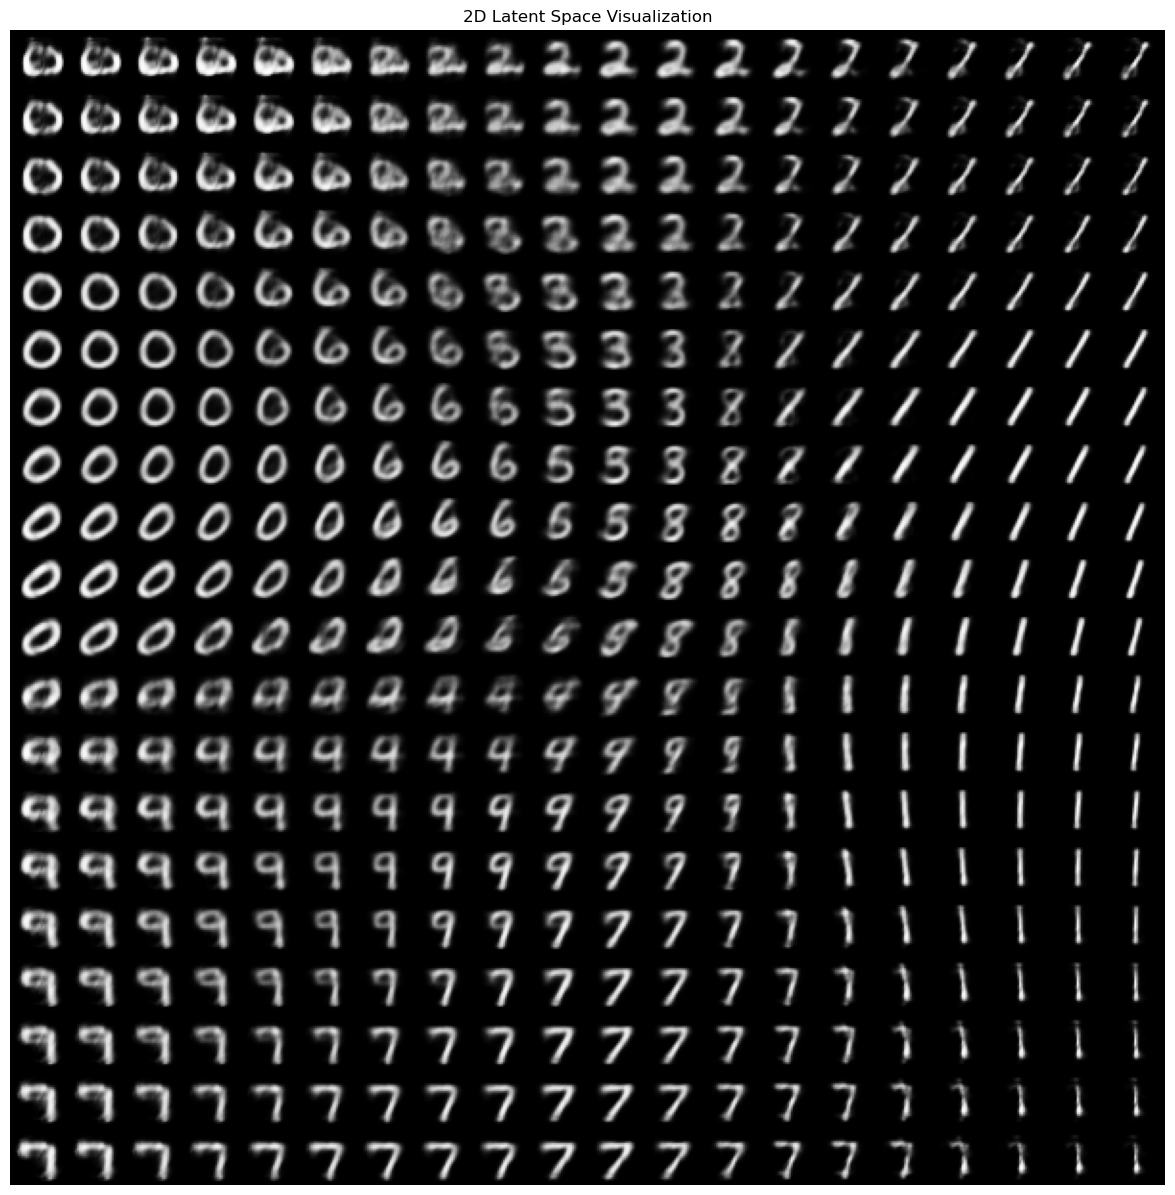

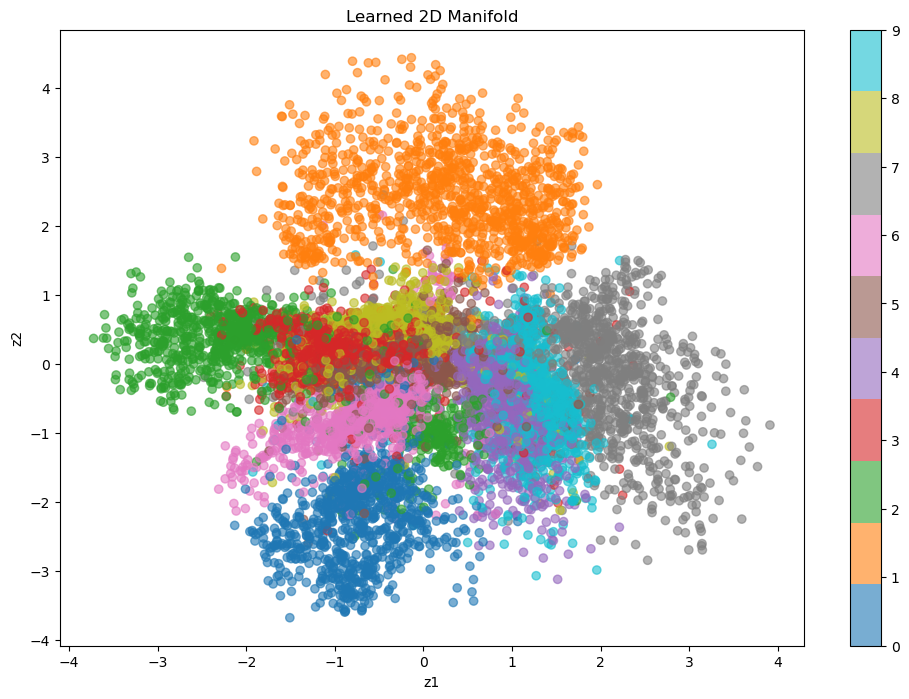

Epoch: 1 Average loss: 208.7264
Epoch: 2 Average loss: 174.1364
Epoch: 3 Average loss: 167.4266
Epoch: 4 Average loss: 163.9635
Epoch: 5 Average loss: 159.7697
Epoch: 6 Average loss: 156.0717
Epoch: 7 Average loss: 153.0187
Epoch: 8 Average loss: 150.5897
Epoch: 9 Average loss: 148.8121
Epoch: 10 Average loss: 147.3875
Epoch: 11 Average loss: 146.3038
Epoch: 12 Average loss: 145.3536
Epoch: 13 Average loss: 144.6608
Epoch: 14 Average loss: 143.9497
Epoch: 15 Average loss: 143.3831
Epoch: 16 Average loss: 142.8580
Epoch: 17 Average loss: 142.4403
Epoch: 18 Average loss: 142.0394
Epoch: 19 Average loss: 141.6870
Epoch: 20 Average loss: 141.3214
Epoch: 21 Average loss: 140.9216
Epoch: 22 Average loss: 140.6273
Epoch: 23 Average loss: 140.2959
Epoch: 24 Average loss: 140.0690
Epoch: 25 Average loss: 139.7364
Epoch: 26 Average loss: 139.5295
Epoch: 27 Average loss: 139.2527
Epoch: 28 Average loss: 139.0463
Epoch: 29 Average loss: 138.8330
Epoch: 30 Average loss: 138.7192
Epoch: 31 Average l

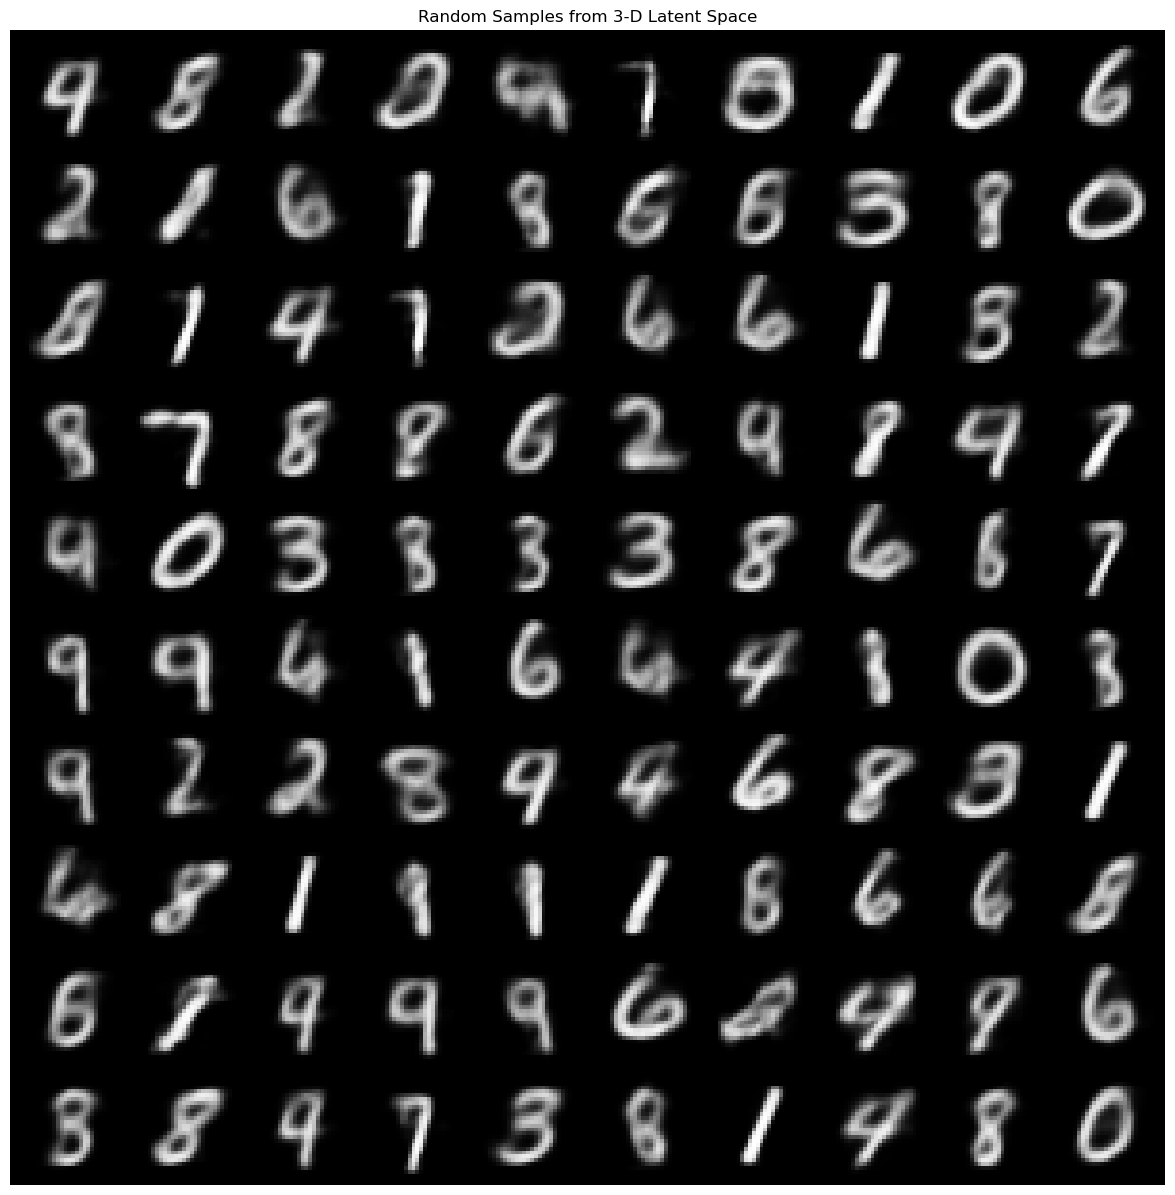

Epoch: 1 Average loss: 205.0546
Epoch: 2 Average loss: 161.6319
Epoch: 3 Average loss: 151.5728
Epoch: 4 Average loss: 146.0742
Epoch: 5 Average loss: 141.6298
Epoch: 6 Average loss: 138.2912
Epoch: 7 Average loss: 135.8013
Epoch: 8 Average loss: 133.9934
Epoch: 9 Average loss: 132.4855
Epoch: 10 Average loss: 131.3192
Epoch: 11 Average loss: 130.2431
Epoch: 12 Average loss: 129.3918
Epoch: 13 Average loss: 128.6477
Epoch: 14 Average loss: 128.0215
Epoch: 15 Average loss: 127.3913
Epoch: 16 Average loss: 126.9225
Epoch: 17 Average loss: 126.5078
Epoch: 18 Average loss: 126.1329
Epoch: 19 Average loss: 125.7272
Epoch: 20 Average loss: 125.3610
Epoch: 21 Average loss: 125.1092
Epoch: 22 Average loss: 124.8465
Epoch: 23 Average loss: 124.5213
Epoch: 24 Average loss: 124.2697
Epoch: 25 Average loss: 124.0947
Epoch: 26 Average loss: 123.8107
Epoch: 27 Average loss: 123.5971
Epoch: 28 Average loss: 123.4250
Epoch: 29 Average loss: 123.2194
Epoch: 30 Average loss: 123.0312
Epoch: 31 Average l

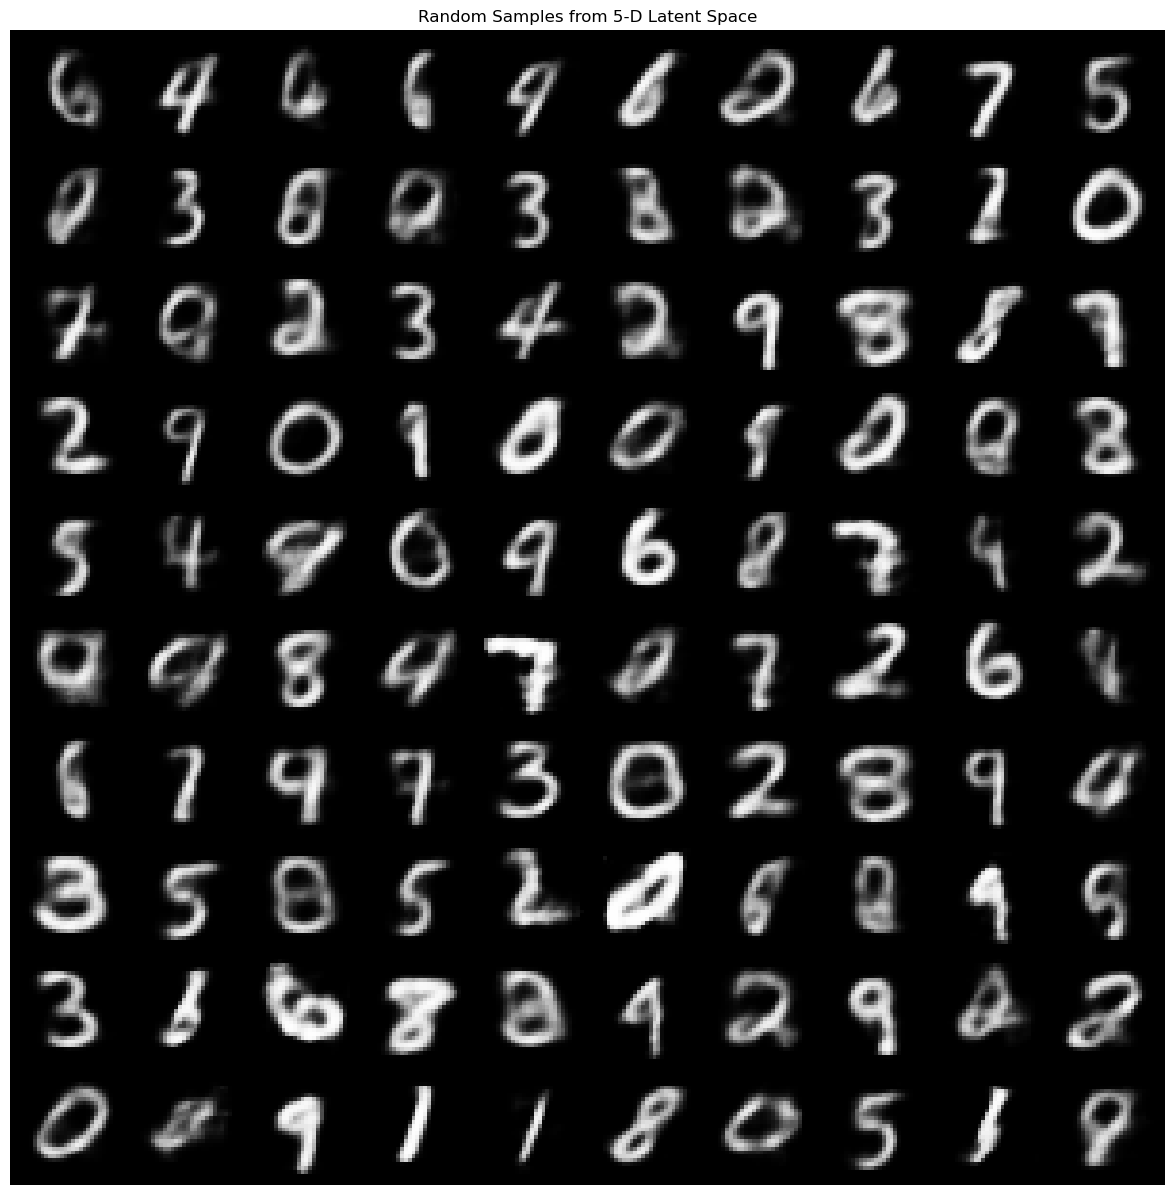

Epoch: 1 Average loss: 206.6830
Epoch: 2 Average loss: 154.7021
Epoch: 3 Average loss: 138.2614
Epoch: 4 Average loss: 131.4159
Epoch: 5 Average loss: 127.0788
Epoch: 6 Average loss: 123.3485
Epoch: 7 Average loss: 120.2714
Epoch: 8 Average loss: 117.9147
Epoch: 9 Average loss: 116.0656
Epoch: 10 Average loss: 114.6031
Epoch: 11 Average loss: 113.4318
Epoch: 12 Average loss: 112.4740
Epoch: 13 Average loss: 111.6567
Epoch: 14 Average loss: 110.9811
Epoch: 15 Average loss: 110.4323
Epoch: 16 Average loss: 109.8860
Epoch: 17 Average loss: 109.4608
Epoch: 18 Average loss: 108.9607
Epoch: 19 Average loss: 108.6869
Epoch: 20 Average loss: 108.3824
Epoch: 21 Average loss: 108.0060
Epoch: 22 Average loss: 107.7777
Epoch: 23 Average loss: 107.5188
Epoch: 24 Average loss: 107.3085
Epoch: 25 Average loss: 107.0510
Epoch: 26 Average loss: 106.8724
Epoch: 27 Average loss: 106.7267
Epoch: 28 Average loss: 106.5180
Epoch: 29 Average loss: 106.3790
Epoch: 30 Average loss: 106.1990
Epoch: 31 Average l

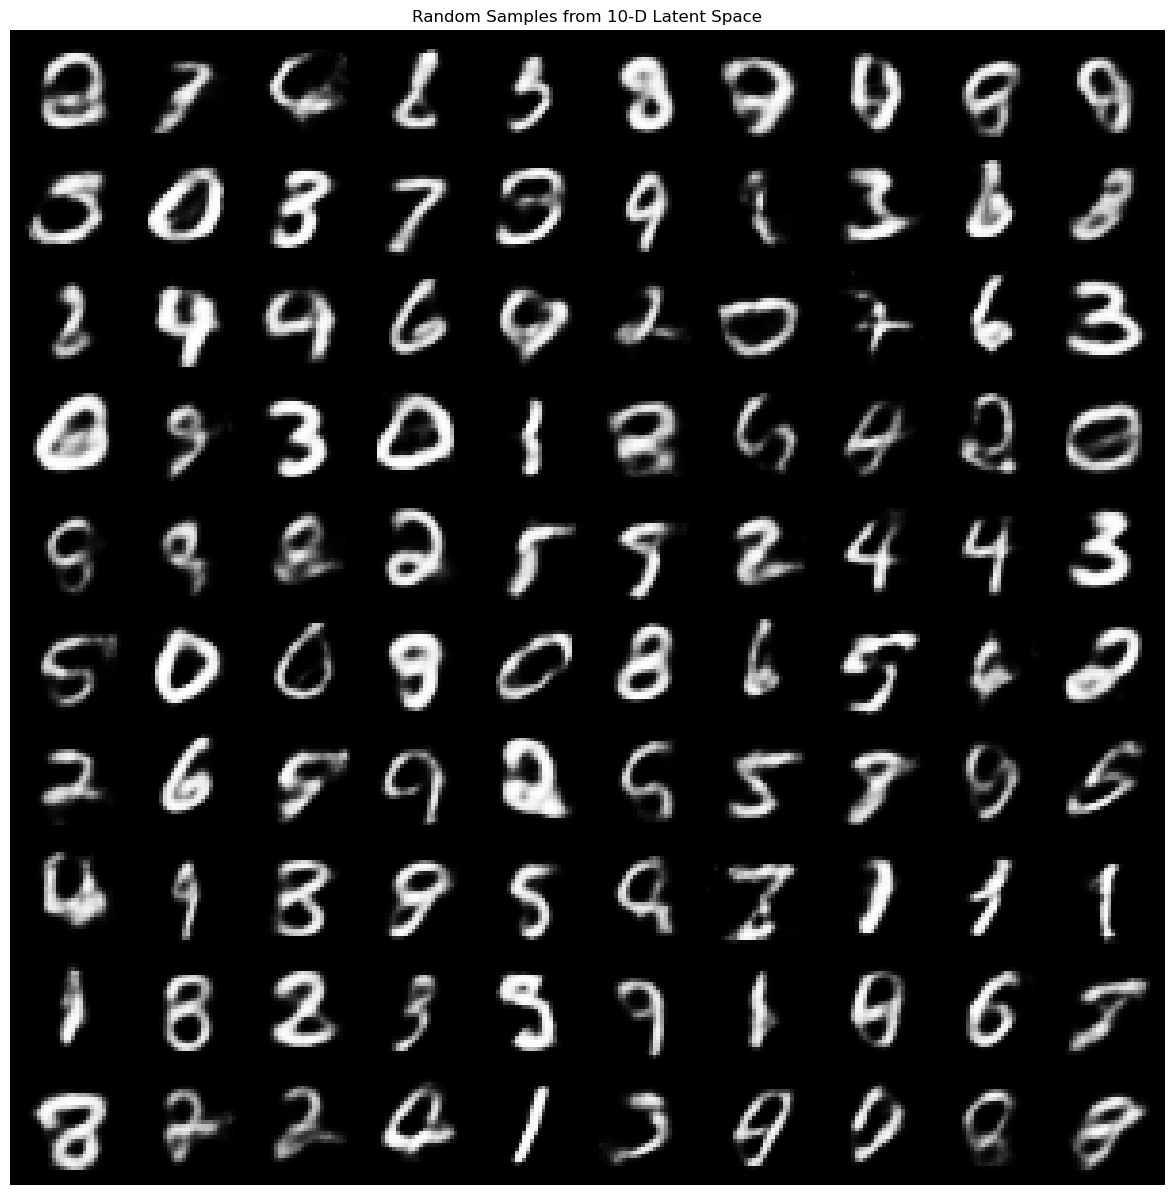

Epoch: 1 Average loss: 202.6456
Epoch: 2 Average loss: 150.9443
Epoch: 3 Average loss: 133.6627
Epoch: 4 Average loss: 125.2336
Epoch: 5 Average loss: 119.5154
Epoch: 6 Average loss: 115.4357
Epoch: 7 Average loss: 112.6367
Epoch: 8 Average loss: 110.7376
Epoch: 9 Average loss: 109.3283
Epoch: 10 Average loss: 108.1469
Epoch: 11 Average loss: 107.2246
Epoch: 12 Average loss: 106.5366
Epoch: 13 Average loss: 105.9392
Epoch: 14 Average loss: 105.5176
Epoch: 15 Average loss: 105.1010
Epoch: 16 Average loss: 104.8068
Epoch: 17 Average loss: 104.4022
Epoch: 18 Average loss: 104.1421
Epoch: 19 Average loss: 103.8839
Epoch: 20 Average loss: 103.7434
Epoch: 21 Average loss: 103.5652
Epoch: 22 Average loss: 103.3368
Epoch: 23 Average loss: 103.1461
Epoch: 24 Average loss: 103.0047
Epoch: 25 Average loss: 102.8434
Epoch: 26 Average loss: 102.7705
Epoch: 27 Average loss: 102.6097
Epoch: 28 Average loss: 102.4351
Epoch: 29 Average loss: 102.3523
Epoch: 30 Average loss: 102.3078
Epoch: 31 Average l

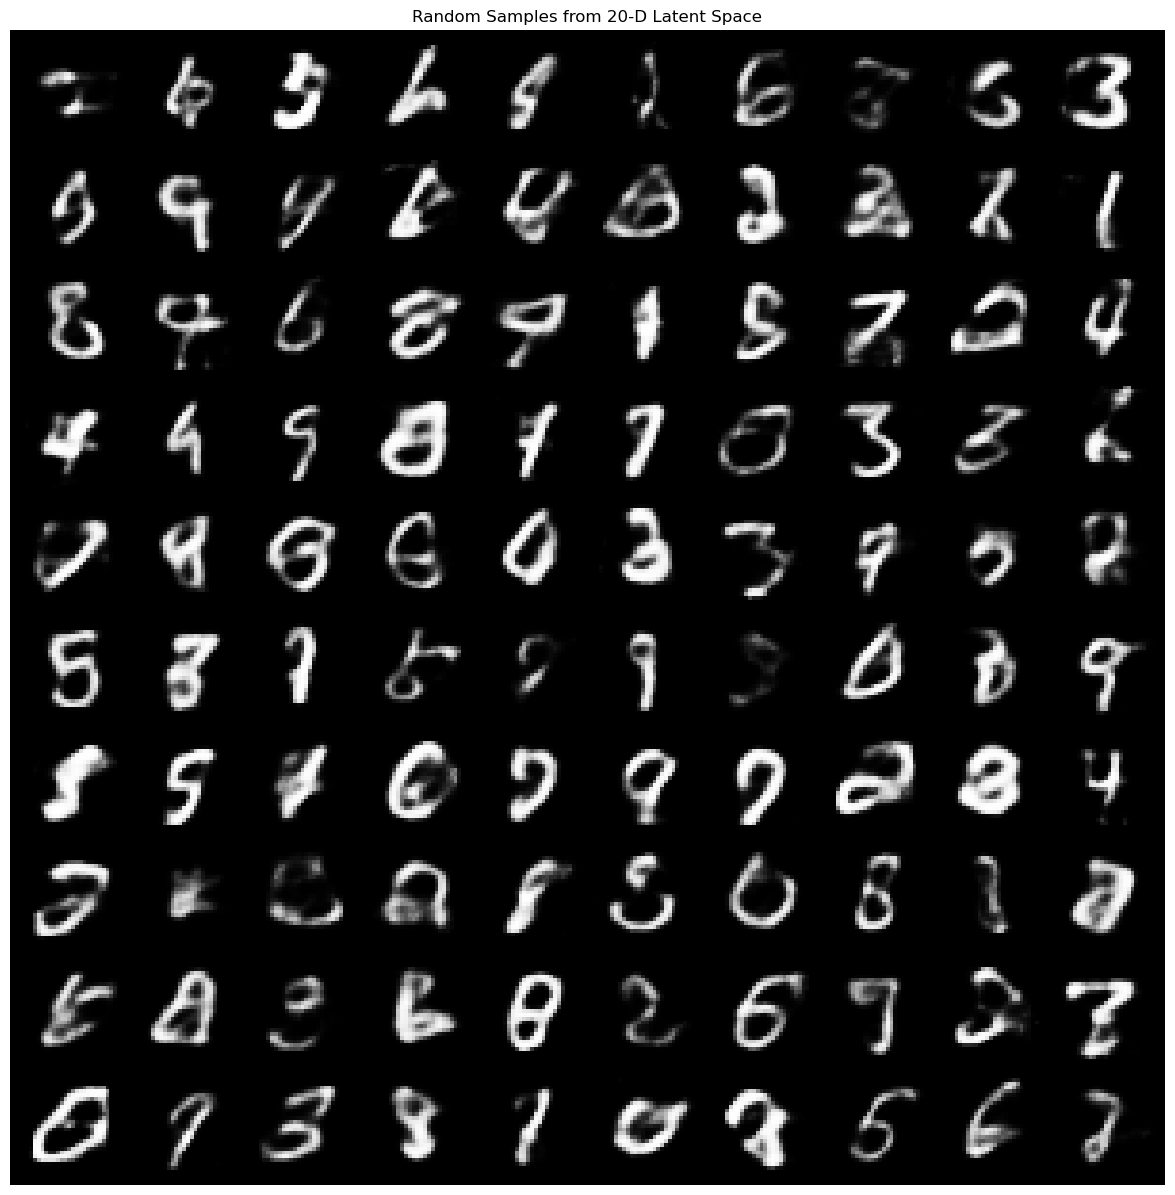

In [13]:
from torchvision.utils import make_grid
results = {}
for nz in [2, 3, 5, 10, 20]:
    model = VAE(input_dim, hidden_dim, nz).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    losses = []
    training_curves = {
        'lower_bound': [],
        'samples_processed': [],
    }
    
    for epoch in range(1, num_epochs + 1):
        loss, lower_bounds, samples = train_elbo(model, train_loader, optimizer, epoch, device)
        losses.append(loss)
        training_curves['lower_bound'].extend(lower_bounds)
        training_curves['samples_processed'].extend(samples)
    
    results[nz] = {
        'training_curves': training_curves,
        'model': model
    }
    
    model.eval()  
    
    plt.figure(figsize=(15, 15))
    
    if nz == 2:
        x = np.linspace(-3, 3, 20)
        y = np.linspace(-3, 3, 20)
        z_grid = torch.zeros((400, 2))
        
        idx = 0
        for i in x:
            for j in y:
                z_grid[idx] = torch.tensor([i, j])
                idx += 1
        
        with torch.no_grad():
            z_grid = z_grid.to(device)
            samples = model.decode(z_grid)
            samples = samples.view(-1, 1, 28, 28)  
            samples = samples.cpu()
            
        grid_img = make_grid(samples, nrow=20, normalize=True)
        plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')
        plt.title(f'2D Latent Space Visualization')
        
    else:
        z = torch.randn(100, nz).to(device)
        
        with torch.no_grad():
            samples = model.decode(z)
            samples = samples.view(-1, 1, 28, 28) 
            samples = samples.cpu()
            
        grid_img = make_grid(samples, nrow=10, normalize=True)
        plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')
        plt.title(f'Random Samples from {nz}-D Latent Space')
    
    plt.axis('off')
    plt.show()
    
    if nz == 2:
        plt.figure(figsize=(12, 8))
        z_means = []
        labels = []
        
        with torch.no_grad():
            for batch_idx, (data, label) in enumerate(test_loader):
                data = data.to(device)
                data = data.view(-1, input_dim)  
                mu, _ = model.encode(data)
                z_means.append(mu.cpu().numpy())
                labels.append(label.numpy())
        
        z_means = np.concatenate(z_means, axis=0)
        labels = np.concatenate(labels, axis=0)
        
        scatter = plt.scatter(z_means[:, 0], z_means[:, 1], 
                            c=labels, cmap='tab10', alpha=0.6)
        plt.colorbar(scatter)
        plt.xlabel('z1')
        plt.ylabel('z2')
        plt.title('Learned 2D Manifold')
        plt.show()

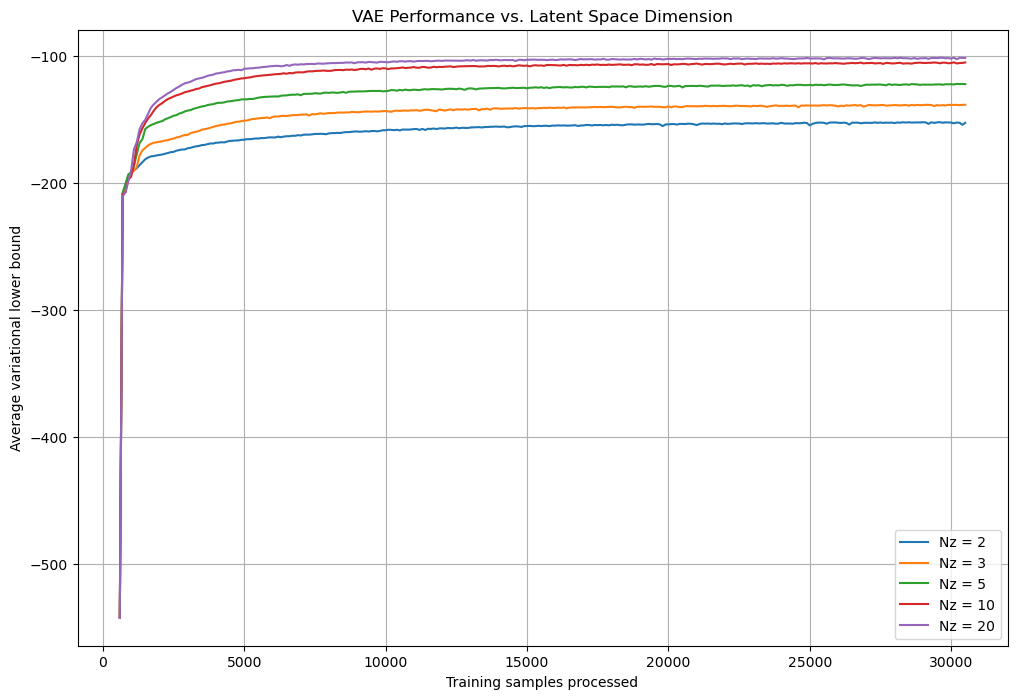

In [27]:
def plot_dimension_comparison(results, save_path="vae_comparison_latent.pdf"):
    plt.figure(figsize=(12, 8))
    
    for nz, curves in results.items():
        plt.plot(curves['training_curves']['samples_processed'], curves['training_curves']['lower_bound'], 
                label=f'Nz = {nz}')
    
    plt.xlabel('Training samples processed')
    plt.ylabel('Average variational lower bound')
    plt.title('VAE Performance vs. Latent Space Dimension')
    plt.legend()
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path)
    plt.show()
     
plot_dimension_comparison(results)

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from scipy.stats import norm
from torch.utils.data import DataLoader

def generate_samples(model, num_samples):
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decode(z)
    return samples

def evaluate_vae(model, test_loader, device):
    model.eval()
    total_loss = 0
    total_bce = 0
    total_kld = 0
    
    original_images = []
    reconstructed_images = []
    
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, log_var = model(data)
            
            bce = F.binary_cross_entropy(recon_batch, data.view(-1, 784), reduction='sum')
            kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = bce + kld
            
            total_loss += loss.item()
            total_bce += bce.item()
            total_kld += kld.item()
            
            if batch_idx == 0:
                original_images = data[:8]
                reconstructed_images = recon_batch[:8].view(-1, 1, 28, 28)
    
    n_samples = len(test_loader.dataset)
    metrics = {
        'avg_loss': total_loss / n_samples,
        'avg_bce': total_bce / n_samples,
        'avg_kld': total_kld / n_samples
    }
    
    return metrics, original_images, reconstructed_images

def visualize_results(original_images, reconstructed_images, samples=None, save_path=None):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    grid = make_grid(original_images, nrow=4, normalize=True)
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)), cmap='gray')
    plt.title('Original Images')
    plt.axis('off')
    
    plt.subplot(132)
    grid = make_grid(reconstructed_images, nrow=4, normalize=True)
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)), cmap='gray')
    plt.title('Reconstructed Images')
    plt.axis('off')
    
    if samples is not None:
        plt.subplot(133)
        grid = make_grid(samples.view(-1, 1, 28, 28)[:8], nrow=4, normalize=True)
        plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)), cmap='gray')
        plt.title('Generated Samples')
        plt.axis('off')
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

def interpolate_latent_space(model, start_img, end_img, n_steps=10, device='cuda'):
    model.eval()
    with torch.no_grad():
        mu1, _ = model.encode(start_img.view(-1, 784))
        mu2, _ = model.encode(end_img.view(-1, 784))
        
        alphas = np.linspace(0, 1, n_steps)
        interpolated_images = []
        
        for alpha in alphas:
            z = alpha * mu1 + (1 - alpha) * mu2
            interpolated_img = model.decode(z)
            interpolated_images.append(interpolated_img.view(-1, 1, 28, 28))
        
        return torch.cat(interpolated_images, dim=0)

def analyze_latent_space(model, test_loader, device):
    model.eval()
    latent_vectors = []
    labels = []
    
    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, 784))
            latent_vectors.append(mu.cpu().numpy())
            labels.extend(label.numpy())
    
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.array(labels)
    
    return latent_vectors, labels

def run_evaluation(model, test_loader, device):
    print("Running evaluation...")
    metrics, orig_imgs, recon_imgs = evaluate_vae(model, test_loader, device)
    print(f"Average Loss: {metrics['avg_loss']:.4f}")
    print(f"Average BCE: {metrics['avg_bce']:.4f}")
    print(f"Average KLD: {metrics['avg_kld']:.4f}")
    
    samples = generate_samples(model, 8)

    print("\nGenerating visualizations...")
    visualize_results(orig_imgs, recon_imgs, samples, save_path='vae_results.pdf')
    
    return metrics, labels

Running evaluation...
Average Loss: 101.1053
Average BCE: 76.4414
Average KLD: 24.6638

Generating visualizations...


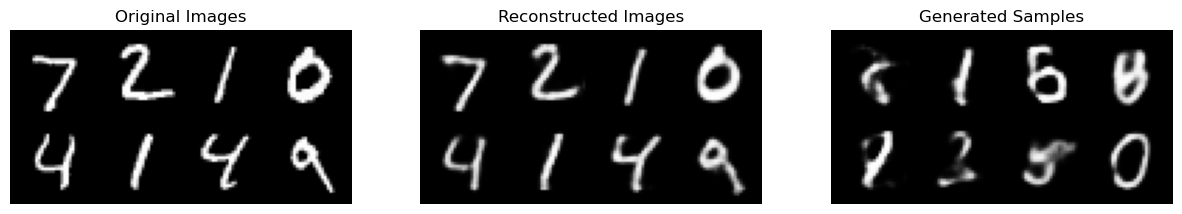

In [28]:
metrics, labels = run_evaluation(model_elbo, test_loader, device)

Running evaluation...
Average Loss: 101.1612
Average BCE: 76.1481
Average KLD: 25.0131

Generating visualizations...


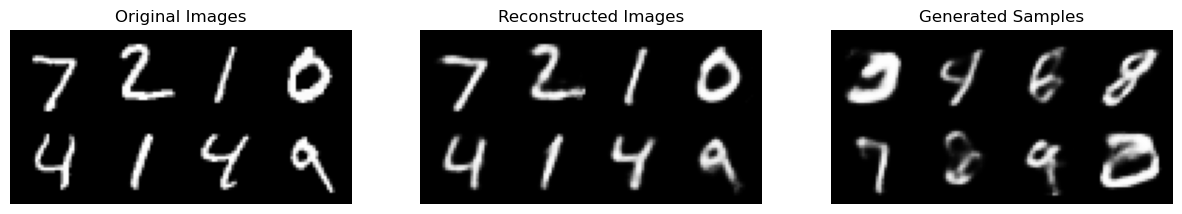

In [29]:
metrics, labels = run_evaluation(model_ws, test_loader, device)